In [2]:
import torch
from torch import nn,optim

In [3]:
from datasets import load_dataset
import datasets
import os

train_file = []
test_file = []
for file in os.listdir("./spdataset"):
    if file.endswith("news.parquet"):
        if "train" in file:
            train_file.append(os.path.join("./spdataset", file))
        if "test" in file:
            test_file.append(os.path.join("./spdataset", file))


dataset = load_dataset("parquet", data_files={"train": train_file, "test": test_file})
dataset.set_format("torch", columns=["x", "y_hat", "y_avg","x_news","y_news"],output_all_columns=True)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start_date', 'ts_code', 'x', 'y_hat', 'y_avg', 'x_news', 'y_news', 'window_size'],
        num_rows: 749
    })
    test: Dataset({
        features: ['start_date', 'ts_code', 'x', 'y_hat', 'y_avg', 'x_news', 'y_news', 'window_size'],
        num_rows: 42
    })
})

In [9]:
class GRU(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
        # Xavier initialization
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            else:
                nn.init.zeros_(param)

    def init_hidden(self, batch_size):
        return (torch.rand(self.num_layers, batch_size, self.hidden_size) * 0.01).to('cuda')

    def forcast(self, x, h0, forcast_length):
        forcast_out = torch.zeros(x.shape[0], forcast_length).to('cuda')
        for i in range(forcast_length):
            # teaching force
            # x -> (B,L)
            x = x.unsqueeze(2)
            # x -> (B,L,1)
            out, h1 = self.gru(x, h0)
            # out -> (B,L,H)
            out = self.fc(out[:, -1, :])
            # out -> (B,1)
            forcast_out[:, i] = out.squeeze()
            x = out
            h0 = h1
        return torch.mean(forcast_out, 1), h1

    def forward(self, x, h0=None, forcast_length=1, **args):
        if h0 is None:
            h0 = self.init_hidden(x.shape[0])
        return self.forcast(x, h0, forcast_length)

In [10]:
gru = GRU(hidden_size=32, num_layers=4).to("cuda")

In [16]:
from torchsummary import summary
summary(gru, input_size=(32,),batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 32, 32], [-1, 2, 32]]               0
            Linear-2                   [128, 1]              33
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.50
Params size (MB): 0.00
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


train loss 0.001462, test loss 0.003640


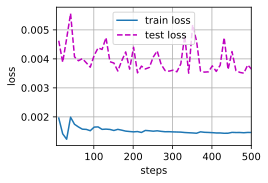

In [ ]:
from utils.trainer import GRU_trainer

optimizer = optim.Adam(gru.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

GRU_trainer(
    model=gru,
    dataset=dataset,
    num_steps=500,
    batch_size=8,
    optimizer=optimizer,
    loss_fn=loss_fn,
    forcast_length=3,
    test_loss_sample_rate=10,
)

Text(152.16666666666669, 0.5, 'num_layer')

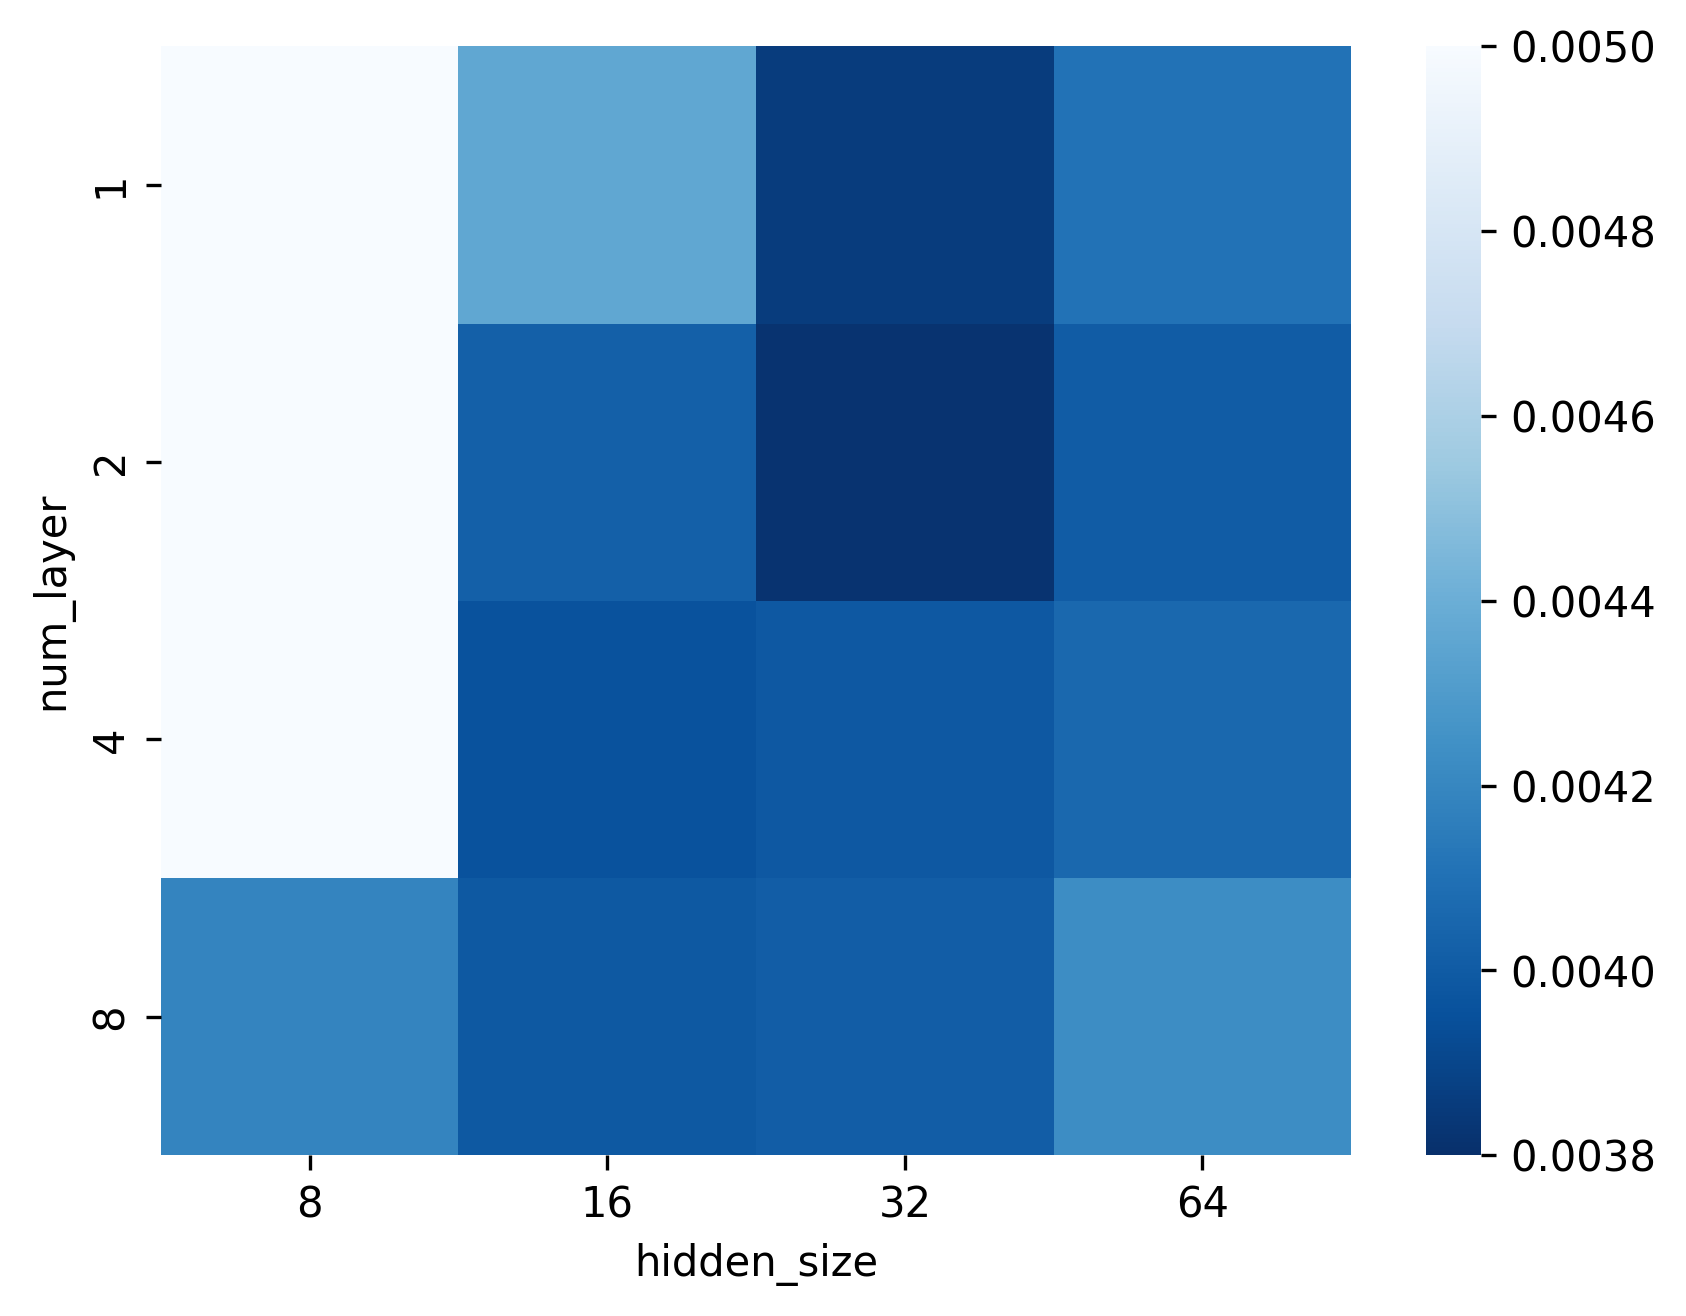

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import palettable#python颜色库

df = pd.DataFrame(
    [
        [0.124721, 0.004361, 0.003860, 0.004107],
        [0.080830, 0.004024, 0.003818, 0.004005],
        [0.028030, 0.003956, 0.003987, 0.004061],
        [0.004187, 0.003991, 0.004007, 0.004228],
    ],
    index=["1", "2", "4", "8"],  # DataFrame的行标签设置为大写字母
    columns=['8','16','32','64'],
)  # 设置DataFrame的列标签

plt.figure(dpi=300)
sns.heatmap(
    data=df,vmin=0.0038,vmax=0.005,cmap='Blues_r'# 矩阵数据集，数据的index和columns分别为heatmap的y轴方向和x轴方向标签
)

plt.xlabel('hidden_size')  # 设置x轴标签
plt.ylabel('num_layer')     # 设置y轴标签
# plt.title("所有参数默认")

,8,16,32,64
1,0.124721,0.004361,0.003860,0.004107
2,0.080830,0.004024,0.003818,0.004005
4,0.028030,0.003956,0.003987,0.004061
8,0.004187,0.003991,0.004007,0.004228
